In [1]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import warnings
# warnings.filterwarnings('ignore',category=DeprecationWarning)

In [2]:
qc = QuantumCircuit(3)

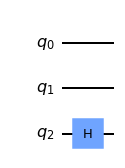

In [3]:
qc.h(2)
qc.draw(output='mpl')

In [4]:
qc.cp(pi/2,1,2)
qc.cp(pi/4,0,2)

In [5]:
qc.h(1)
qc.cp(pi/2,0,1)
qc.h(0)
qc.draw(output='mpl')
print(qc.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
h q[2];
cp(pi/2) q[1],q[2];
cp(pi/4) q[0],q[2];
h q[1];
cp(pi/2) q[0],q[1];
h q[0];



In [6]:
qc.swap(0,2)

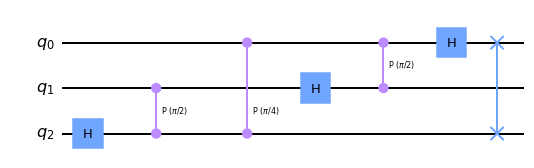

In [7]:
qc.draw(output='mpl')

In [8]:
def qft_rotation(qc,n):
    if n == 0:
        return qc
    n -= 1
    qc.h(n)
    for qbits in range(n):
        qc.cp(pi/(2**(n-qbits)),qbits,n)
    qft_rotation(qc,n)
    return qc

In [9]:
qc = QuantumCircuit(4)
qc = qft_rotation(qc,4)

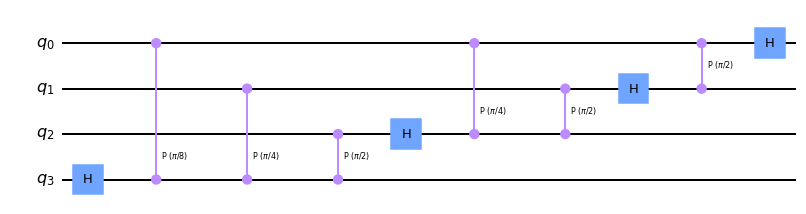

In [10]:
qc.draw(output='mpl')

In [11]:
def swap_register(qc,n):
    for i in range(n//2):
        qc.swap(i,n-1-i)
    return qc

In [12]:
def QFT(qc,n):
    qc = qft_rotation(qc,n)
    qc = swap_register(qc,n)
    return qc

In [13]:
qc = QuantumCircuit(3)

In [14]:
qc.x(0)
qc.x(2)

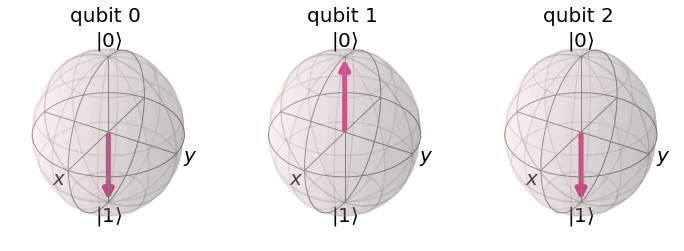

In [15]:
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

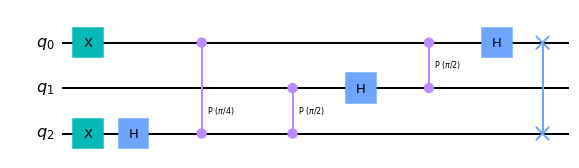

In [16]:
QFT(qc,3).draw(output='mpl')

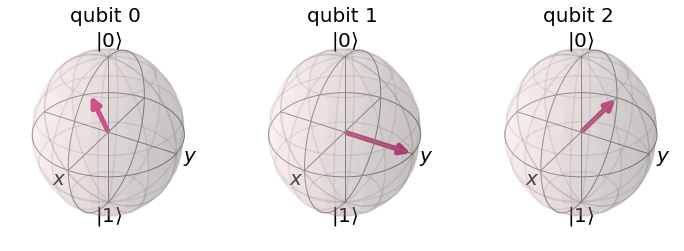

In [17]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

In [18]:
def inverse_qft(qc,n):
    qft = QFT(QuantumCircuit(n),n)
    qft_inv = qft.inverse()
    qc.append(qft_inv,qc.qubits[:n])
    return qc.decompose()

In [19]:
nqubits = 3
number = 4

In [20]:
# from qiskit import QuantumCircuit
qc = QuantumCircuit(nqubits)
for i in range(nqubits):
    qc.h(i)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

In [21]:
qc.draw(output='mpl')
print(qc.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
h q[0];
h q[1];
h q[2];
p(pi) q[0];
p(2*pi) q[1];
p(4*pi) q[2];



In [22]:
# qc.save_statevector()
# statevector = sim.run(qc).result().get_statevector()
# plot_bloch_multivector(statevector)

In [23]:
qc = inverse_qft(qc,3)

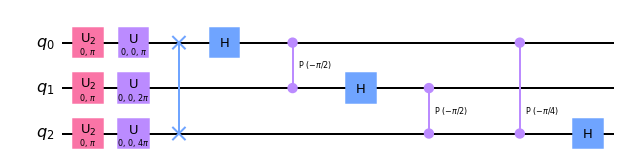

In [24]:
qc.draw(output='mpl')

In [25]:
qc.measure_all()

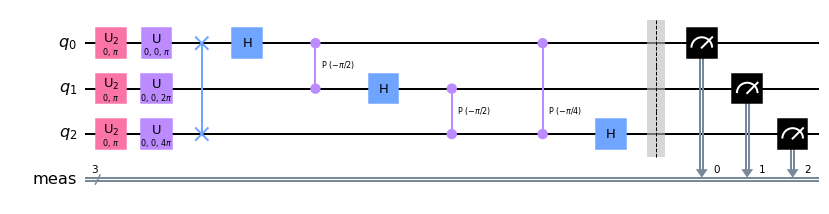

In [26]:
qc.draw(output='mpl')

In [27]:
print(qc.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
creg meas[3];
u2(0,pi) q[0];
u(0,0,pi) q[0];
u2(0,pi) q[1];
u(0,0,2*pi) q[1];
u2(0,pi) q[2];
u(0,0,4*pi) q[2];
swap q[0],q[2];
h q[0];
cp(-pi/2) q[0],q[1];
h q[1];
cp(-pi/2) q[1],q[2];
cp(-pi/4) q[0],q[2];
h q[2];
barrier q[0],q[1],q[2];
measure q[0] -> meas[0];
measure q[1] -> meas[1];
measure q[2] -> meas[2];



In [28]:
from qiskit import IBMQ

In [30]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [34]:
def get_backend(nqubits):
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
    return backend
backend = get_backend(3) #max 5
print("least busy backend: ", backend)

least busy backend:  ibmq_lima


In [35]:
shots = 2048
transpiled_qc = transpile(qc,backend)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job)

Job Status: job has successfully run


In [32]:
# from qiskit import execute
# simulator = Aer.get_backend('qasm_simulator')
# job = execute(qc, simulator, shots=2000)
# result = job.result()

In [36]:
res = job.result()

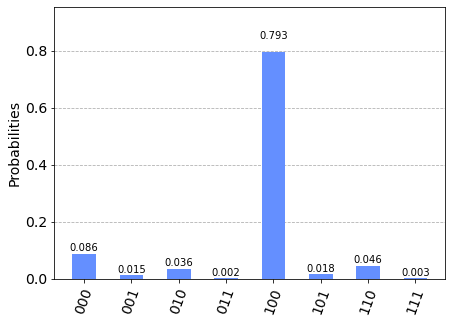

In [38]:
plot_histogram(res.get_counts())

In [ ]:
from qiskit.providers.aer import unitary_simulator